# Libraries

In [29]:
import pandas as pd
import numpy as np
import inflection

from matplotlib import pyplot as plt
from sklearn import preprocessing as pp

# Loading Data

In [2]:
pwd

'/Users/lucasquemelli/Documents/repos/tesla_stock_price_prediction'

In [4]:
data = pd.read_csv("/Users/lucasquemelli/Documents/repos/tesla_stock_price_prediction/TSLA.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [7]:
cols_old = data.columns

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

data.columns = cols_new

data.rename(columns={"adj close": "adj_close"}, inplace=True)

In [8]:
data.columns

Index(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume'], dtype='object')

# Deduplication Test

Since this analysis should be at date level, would it be affordable to have more rows than dates?

In [9]:
data["date"].nunique()

2956

In [10]:
data.shape[0]

2956

Since we cannot use data from a far past to predict stock price of the next month or week, we used only data from the last 8 years. Each row represents data from each date.

# Data Description

In [11]:
data.dtypes

date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object

In [12]:
data.isna().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [13]:
data["date"] = pd.to_datetime(data["date"])

In [14]:
data.dtypes

date         datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume                int64
dtype: object

# Exploratory Data Analysis (EDA)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       2956 non-null   datetime64[ns]
 1   open       2956 non-null   float64       
 2   high       2956 non-null   float64       
 3   low        2956 non-null   float64       
 4   close      2956 non-null   float64       
 5   adj_close  2956 non-null   float64       
 6   volume     2956 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 161.8 KB


In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2956.0,1.386913e+02,2.500448e+02,3.228,1.962700e+01,4.665700e+01,6.805700e+01,1.234410e+03
high,2956.0,1.417716e+02,2.558632e+02,3.326,2.040200e+01,4.748700e+01,6.935750e+01,1.243490e+03
low,2956.0,1.354260e+02,2.437742e+02,2.996,1.912750e+01,4.582000e+01,6.691150e+01,1.217000e+03
close,2956.0,1.387622e+02,2.501231e+02,3.160,1.961500e+01,4.654500e+01,6.810400e+01,1.229910e+03
adj_close,2956.0,1.387622e+02,2.501231e+02,3.160,1.961500e+01,4.654500e+01,6.810400e+01,1.229910e+03
volume,2956.0,3.131449e+07,2.798383e+07,592500.000,1.310288e+07,2.488680e+07,3.973875e+07,3.046940e+08


# High and low prices of Tesla stock

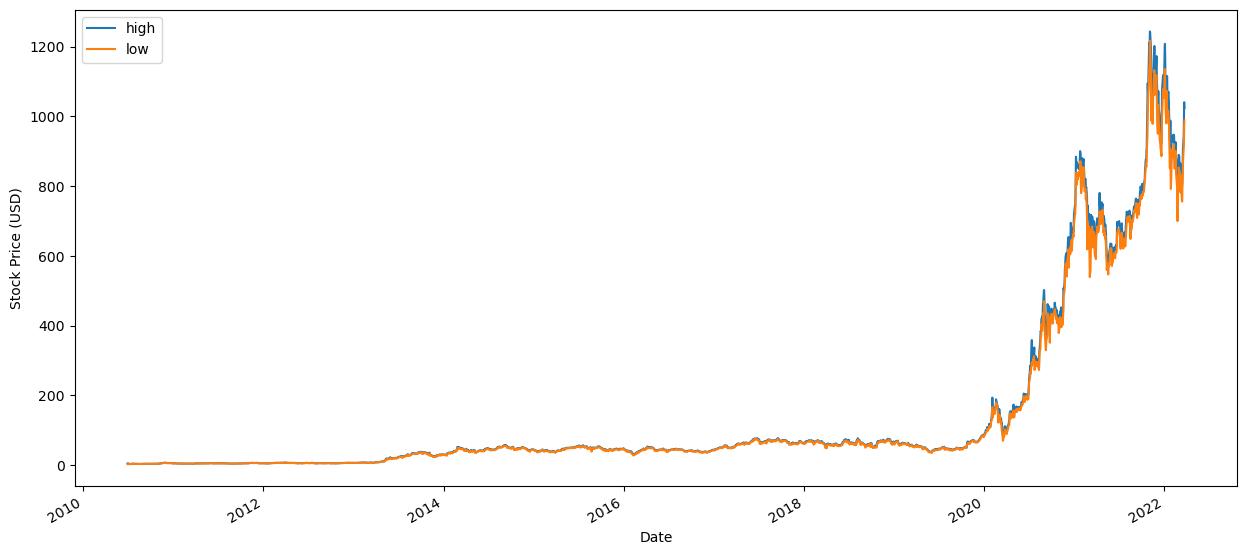

In [20]:
plt.figure(figsize=(15, 7))

plt.plot(data["date"], data["high"], label="high")
plt.plot(data["date"], data["low"], label="low")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# Open and close prices of Tesla stock

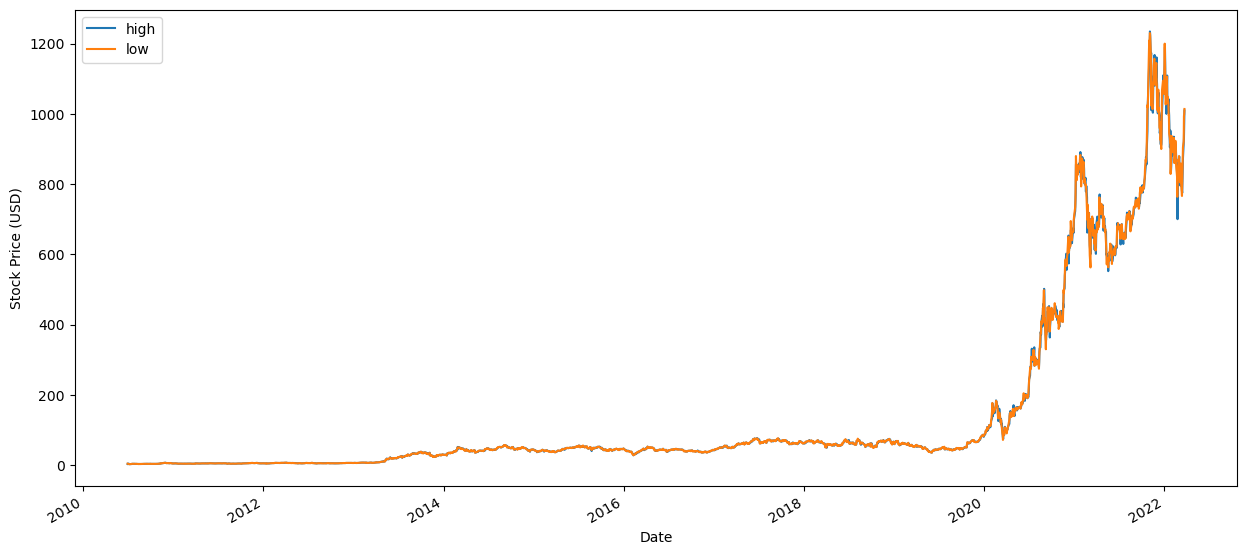

In [21]:
plt.figure(figsize=(15, 7))

plt.plot(data["date"], data["open"], label="high")
plt.plot(data["date"], data["close"], label="low")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# Libraries for Stock Prediction

In [23]:
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# Check stationary data

In [24]:
data.head()

,date,open,high,low,close,adj_close,volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [26]:
def check_stationarity(data):
    result = adfuller(data)
    p_value = result[1]
    return p_value

closing_price = data['close']

# Check for stationarity
p_value = check_stationarity(closing_price)

# If p-value is less than 0.05, data is stationary
if p_value < 0.05:
    print(f"Data is stationary: {p_value}.")
else:
    print(f"Data is non-stationary: {p_value}.")


Data is non-stationary: 0.9972202364261444.


# Data Preprocessing

In [27]:
# Selecting the target variable "close" from the 'data' DataFrame
target_y = data["close"]

# Selecting the first three columns of the 'data' DataFrame as features
data = data.iloc[:, 0:3]

In [30]:
# Feature scaling using StandardScaler from the preprocessing module
sc = pp.StandardScaler()

# Scaling the features in 'x_feat' using the StandardScaler
data["open"] = sc.fit_transform(data[["open"]].values)
data["high"] = sc.fit_transform(data[["high"]].values)

target_y = sc.fit_transform(target_y.values.reshape(-1, 1))

# into DataFrame
data = pd.DataFrame(columns=data.columns,
                      data=data,
                      index=data.index)

In [31]:
df = pd.concat([data, pd.DataFrame(target_y, columns=['target_y'])], axis=1)
df.rename(columns={"target_y": "target"}, inplace=True)

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

df.drop(columns=["date"], inplace=True)

df.head()

,open,high,target,year,month,day
0,-0.539560,-0.534640,-0.535764,2010,6,29
1,-0.534128,-0.530403,-0.535812,2010,6,30
2,-0.534760,-0.533921,-0.537307,2010,7,1
3,-0.536360,-0.536126,-0.539514,2010,7,2
4,-0.538760,-0.538549,-0.541986,2010,7,6


# Train-Test Split

In [32]:
# Assuming we want to use 80% of the data for training
train_size = int(len(closing_price) * 0.8)
train, test = closing_price[:train_size], closing_price[train_size:]

# Auto-ARIMA for Optimal Parameters

In [33]:
# Use auto_arima to find optimal parameters
arima_model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7754.044, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7746.116, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7748.055, Time=0.09 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7748.055, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7745.293, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7750.055, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.835 seconds


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


# Train ARIMA Model

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model with optimal parameters on the training set
model = ARIMA(train, order=arima_model.order)
fitted_model = model.fit()

# Prediction

In [42]:
# Predict on the test set
predictions = fitted_model.forecast(steps=len(test))

In [43]:
predictions

2364    70.433998
2365    70.433998
2366    70.433998
2367    70.433998
2368    70.433998
          ...    
2951    70.433998
2952    70.433998
2953    70.433998
2954    70.433998
2955    70.433998
Name: predicted_mean, Length: 592, dtype: float64

In [44]:
test

2364      69.998001
2365      71.903999
2366      70.444000
2367      70.966003
2368      66.608002
           ...     
2951     905.390015
2952     921.159973
2953     993.979980
2954     999.109985
2955    1013.919983
Name: close, Length: 592, dtype: float64

Mean Squared Error: 328854.2352808474


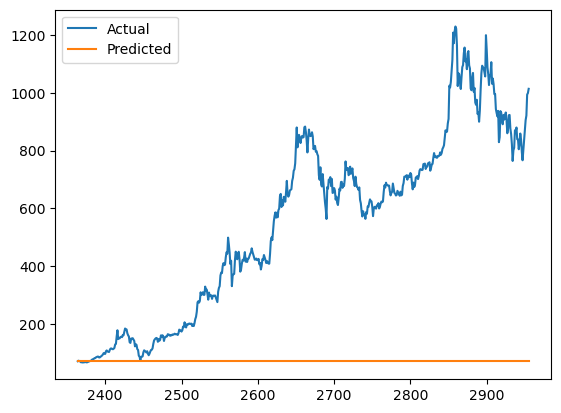

In [45]:
# Calculate Mean Squared Error
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error: {mse}")

# Plotting actual vs predicted values
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.legend()
plt.show()

- It seems ARIMA is not a good model to predict TESLA stock price.
- It may have happened since data is non-stationary.
- ARIMA only works for stationary data.
- Next step is to use LSTM model.

# LSTM train and test split

So, the next step would be to split it into training and testing sets. The training of an LSTM model requires a window or a timestep of data in each training step. For instance, the LSTM will take 10 data samples to predict the 10th one by weighing the first nine input samples in one step. So, we need a different approach than the train_test_split provided by scikit-learn.

Let’s define a splitting function called lstm_split() which will make windows of size “n_steps” starting from the first sample of data and ending at n_steps’th sample (if n_steps=10, then the 10th sample) from the end. We understand the latter part because, for each time step, LSTM will take n_steps-1 samples for training and predict the last sample. Loss calculation is done based on the error in this prediction. So if n_steps=10, you cannot use the last 9 samples to predict anything because the “10th” data point for the current step does not exist in the dataset.

The function below takes the entire data and creates windows of size n_steps starting from the beginning. The target y will contain the target value corresponding to the n_steps’th index. So if n_steps is 10, the first element in X will have features from 10 data samples, and y will contain the target of the 10th data sample.

We split our data into training and testing sets. Shuffling is not permitted in time-series datasets. In the beginning, we take two steps worth of past data to predict the current value. Thus, the model will look at yesterday’s and today’s values to predict today’s closing price.

In [107]:
df = pd.concat([data, pd.DataFrame(target_y, columns=['target_y'])], axis=1)
df.rename(columns={"target_y": "target"}, inplace=True)

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

#df.drop(columns=["date"], inplace=True)

df.head()

,date,open,high,target,year,month,day
0,2010-06-29,-0.539560,-0.534640,-0.535764,2010,6,29
1,2010-06-30,-0.534128,-0.530403,-0.535812,2010,6,30
2,2010-07-01,-0.534760,-0.533921,-0.537307,2010,7,1
3,2010-07-02,-0.536360,-0.536126,-0.539514,2010,7,2
4,2010-07-06,-0.538760,-0.538549,-0.541986,2010,7,6


In [111]:
# Convert "year" to datetime
df['date'] = pd.to_datetime(df['date'], format='%YYYY-%MM-%DD')

# Split data for training and testing (2010 to 2021)
train_test = df[(df['date'] >= '2010-01-01') & (df['date'] <= '2021-12-31')]

# Split data for validation (from 2022)
validation = df[df['date'] >= '2022-01-01']

train_test.drop(columns="date", inplace=True)
validation.drop(columns="date", inplace=True)

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_28495/3547542704.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test.drop(columns="date", inplace=True)
/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_28495/3547542704.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.drop(columns="date", inplace=True)


In [112]:
train_test.head()

,open,high,target,year,month,day
0,-0.539560,-0.534640,-0.535764,2010,6,29
1,-0.534128,-0.530403,-0.535812,2010,6,30
2,-0.534760,-0.533921,-0.537307,2010,7,1
3,-0.536360,-0.536126,-0.539514,2010,7,2
4,-0.538760,-0.538549,-0.541986,2010,7,6


In [113]:
df["year"].max()

2022

In [114]:
# Sort the DataFrame by the 'year' column to ensure temporal order
train_test = train_test.sort_values(by='year')

# Specify the ratio for the split
train_size = 0.8  # 80% for training, 20% for testing

# Calculate the index for the split
split_index = int(len(train_test) * train_size)

# Split the data into train and test
train = train_test.iloc[:split_index]
test = train_test.iloc[split_index:]

In [115]:
print(train.shape, test.shape)

(2319, 6) (580, 6)


In [116]:
train.head()

,open,high,target,year,month,day
0,-0.539560,-0.534640,-0.535764,2010,6,29
95,-0.531880,-0.531435,-0.532445,2010,11,11
94,-0.535176,-0.530755,-0.531389,2010,11,10
93,-0.534760,-0.534101,-0.535172,2010,11,9
92,-0.535160,-0.534640,-0.534892,2010,11,8


In [117]:
train["year"].max()

2019

In [118]:
test["year"].min()

2019

In [119]:
test["year"].max()

2021

To use LSTM model, we need data points from the last 5 years only. Furthermore, the training is very time-consuming.

In [120]:
train = train[train["year"] >= 2018]
test = test[test["year"] >= 2018]

In [121]:
train.columns

Index(['open', 'high', 'target', 'year', 'month', 'day'], dtype='object')

In [122]:
X_train = train[['open', 'high', 'year', 'month', 'day']]
X_test = test[['open', 'high', 'year', 'month', 'day']]

y_train = train["target"]
y_test = test["target"]

# LSTM Model

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import *

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit 

In [125]:
# 2^n for number input layer higher than 428 :: 2^9
X_train.shape[0]

428

In [126]:
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 2  # experiment with this value
X_train, y_train = create_dataset(train.values, time_steps)
X_test, y_test = create_dataset(test.values, time_steps)

# Reshape to (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [127]:
# instantiate model
model = Sequential()

# first layer :: 2^12 neurons :: first 2^n value higher than 473
model.add(LSTM(units=512, input_shape=(X_train.shape[1], 1)))

# last layer :: only 1 target variable
model.add(Dense(units=1))

# error evaluation
model.compile(optimizer='adam', loss='mean_squared_error')

In [128]:
# Displaying a summary of the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 512)               1052672   
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


In [129]:
model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=1, shuffle=False)

Epoch 1/100
107/107 [==============================] - 3s 13ms/step - loss: 0.0055
Epoch 2/100
107/107 [==============================] - 1s 12ms/step - loss: 7.5194e-04
Epoch 3/100
107/107 [==============================] - 1s 12ms/step - loss: 7.7424e-04
Epoch 4/100
107/107 [==============================] - 1s 12ms/step - loss: 7.7120e-04
Epoch 5/100
107/107 [==============================] - 1s 12ms/step - loss: 7.7022e-04
Epoch 6/100
107/107 [==============================] - 1s 12ms/step - loss: 7.6810e-04
Epoch 7/100
107/107 [==============================] - 1s 12ms/step - loss: 7.6516e-04
Epoch 8/100
107/107 [==============================] - 1s 12ms/step - loss: 7.6217e-04
Epoch 9/100
107/107 [==============================] - 1s 12ms/step - loss: 7.5964e-04
Epoch 10/100
107/107 [==============================] - 1s 12ms/step - loss: 7.5781e-04
Epoch 11/100
107/107 [==============================] - 1s 12ms/step - loss: 7.5689e-04
Epoch 12/100
107/107 [=======================

107/107 [==============================] - 1s 11ms/step - loss: 5.6723e-04
Epoch 95/100
107/107 [==============================] - 1s 11ms/step - loss: 5.6720e-04
Epoch 96/100
107/107 [==============================] - 1s 11ms/step - loss: 5.6691e-04
Epoch 97/100
107/107 [==============================] - 1s 11ms/step - loss: 5.6704e-04
Epoch 98/100
107/107 [==============================] - 1s 11ms/step - loss: 5.6794e-04
Epoch 99/100
107/107 [==============================] - 1s 11ms/step - loss: 5.6654e-04
Epoch 100/100
107/107 [==============================] - 1s 11ms/step - loss: 5.6220e-04


# Prediction

In [130]:
predictions = model.predict(X_test)

19/19 [==============================] - 0s 4ms/step


# Test

In [131]:
# Calculate performance metrics
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 0.382449997113011
MAPE: 0.5554990369086182


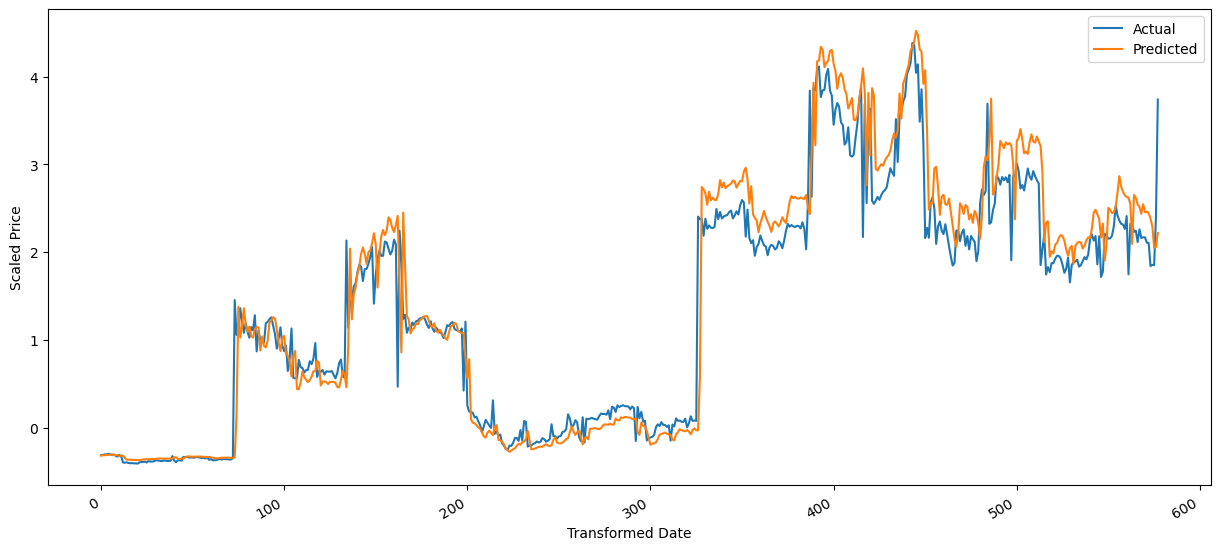

In [132]:
plt.figure(figsize=(15, 7))

plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel("Transformed Date")
plt.ylabel("Scaled Price")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# Validation

In [143]:
validation.head()

,open,high,target,year,month,day
2899,4.036194,4.140796,4.242700,2022,1,3
2900,4.203392,4.167886,4.042005,2022,1,4
2901,4.031794,4.020673,3.796204,2022,1,5
2902,3.753197,3.698806,3.702554,2022,1,6
2903,3.766677,3.671170,3.551643,2022,1,7


In [151]:
val = validation[["open", "high", "year", "month", "day"]].copy()

val = np.array(val.values)
val = np.reshape(val, (val.shape[0], val.shape[1], 1))

In [152]:
pred = model.predict(val)

2/2 [==============================] - 0s 6ms/step


In [163]:
val = validation["target"].copy()

val = np.array(val.values)

In [165]:
# Calculate performance metrics
rmse = mean_squared_error(val, pred, squared=False)
mape = mean_absolute_percentage_error(val, pred)

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 1.928436307219258
MAPE: 0.5968569106868922


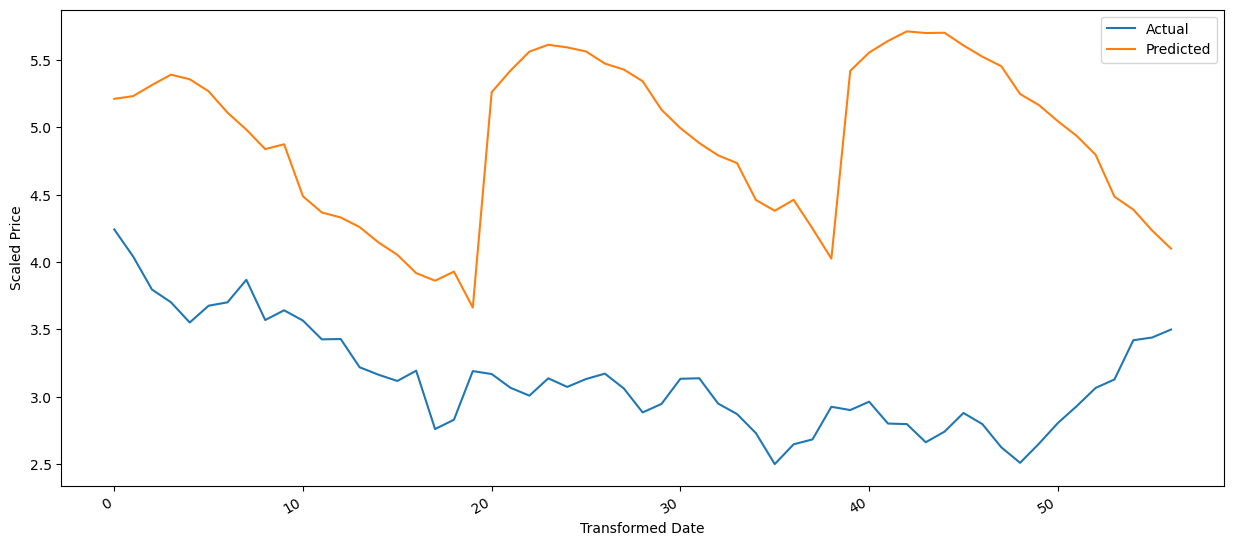

In [166]:
plt.figure(figsize=(15, 7))

plt.plot(val, label='Actual')
plt.plot(pred, label='Predicted')
plt.xlabel("Transformed Date")
plt.ylabel("Scaled Price")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()